# Competition models: non-linear dynamics
## Computational Science with Python
## Yoav Ram

In [6]:
from functools import partial

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy.integrate import solve_bvp, solve_ivp, odeint
from ipywidgets import interact

[Lotka-Volterra models](https://en.wikipedia.org/wiki/Lotka–Volterra_equations) are models of species interactions, which can consist of competition, cooperation, or other types of interactions.

We will focus now on predation.

# Predator-prey model

The predator-prey model is summarized by these equations:

$$
\frac{dx}{dt} = b x - h x y \\
\frac{dy}{dt} = \epsilon h x y - d y
$$

where the parameters are:
- $x$ is the density of the prey (rabbits)
- $y$ is the density of the predator (foxes)
- $b$ is the prey birth rate
- $d$ is the predator death rate
- $h$ is the rate at which, when predator and prey meet, predation occurs
- $\epsilon$ is the rate at which prey density is converted to predator density when predation occurs

[![lynx](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/Lynx_Canadensis.jpg/320px-Lynx_Canadensis.jpg)](https://en.wikipedia.org/wiki/Canada_lynx)
[![hare](https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Snowshoe_Hare%2C_Shirleys_Bay.jpg/254px-Snowshoe_Hare%2C_Shirleys_Bay.jpg)](https://en.wikipedia.org/wiki/Snowshoe_hare)

# Dynamics

To implement the model we first write the ODE as a function:

In [57]:
def dxydt(t, xy, b, h, ϵ, d):
    x, y = xy
    dx = b * x - h * x * y
    dy = ϵ * h * x * y - d * y
    return np.array([dx, dy])

Now we can integrate the ODE for specific values using SciPy's [solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html):

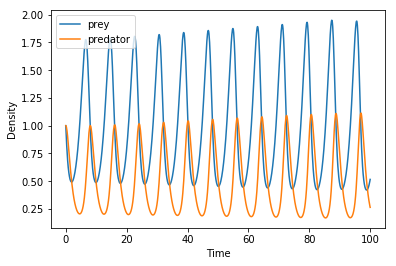

In [58]:
b = 2/3
h = 4/3
ϵ = 3/4
d = 1

t = np.linspace(0, 100, 1000)

xy0 = (1, 1)

_dxydt = partial(dxydt, b=b, h=h, ϵ=ϵ, d=d)
sol = solve_ivp(_dxydt, (t.min(), t.max()), xy0, t_eval=t)

plt.plot(sol.t, sol.y.T)
plt.legend(('prey', 'predator'))
plt.xlabel('Time')
plt.ylabel('Density');

We can explore the dynamics for different values using `interact`:

In [60]:
def solve_plot(x0, y0, tmax, b, h, ϵ, d):
    t = np.linspace(0, tmax, 1000)
    xy0 = (x0, y0)
    _dxydt = partial(dxydt, b=b, h=h, ϵ=ϵ, d=d)
    sol = solve_ivp(_dxydt, (t.min(), t.max()), xy0, t_eval=t)

    plt.plot(sol.t, sol.y.T)
    plt.legend(('prey', 'predator'))
    plt.xlabel('Time')
    plt.ylabel('Density')
    
interact(solve_plot,
          x0=(1, 100, 1), y0=(1, 100, 10), tmax=(1, 1001, 10), 
          b=(0, 1, 0.1), h=(0, 2, 0.1), ϵ=(0, 1, 0.1), d=(0, 2, 0.1));

interactive(children=(IntSlider(value=50, description='x0', min=1), IntSlider(value=41, description='y0', min=1, step=10), IntSlider(value=501, description='tmax', max=1001, min=1, step=10), FloatSlider(value=0.0, description='b', max=1.0), FloatSlider(value=1.0, description='h', max=2.0), FloatSlider(value=0.0, description='ε', max=1.0), FloatSlider(value=1.0, description='d', max=2.0), Output()), _dom_classes=('widget-interact',))

<function __main__.solve_plot>

# Equilibrium

Population equilibrium occurs in the model when neither of the population levels is changing, i.e. when both of the derivatives are equal to 0:

$$
bx - hxy = 0 \\
\epsilon h x y - d y = 0 \Rightarrow \\
x (b - hy) = 0 \\
y (\epsilon h x - d) = 0
$$

The trivial solutions have $x=0$ and/or $y=0$.
Assuming both are positive,

$$
x^* = \frac{d}{\epsilon h} \\
y^* = \frac{b}{h}
$$

In [61]:
b = 2/3
h = 4/3
ϵ = 3/4
d = 1

xy0 = d/(ϵ*h), b/h

dxydt(0, xy0, b=b, h=h, ϵ=ϵ, d=d)

array([ 0.,  0.])

/Users/yoavram/miniconda3/envs/scipy/lib/python3.6/site-packages/scipy/integrate/_ivp/rk.py:145: RuntimeWarning: divide by zero encountered in double_scalars
  max(1, SAFETY * error_norm ** (-1 / (order + 1))))


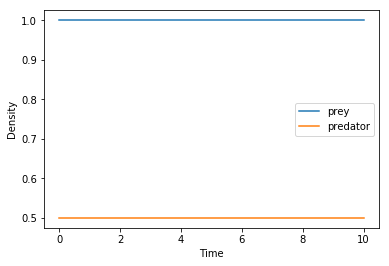

In [62]:
solve_plot(x0=d/(ϵ*h), y0=b/h, tmax=10, b=b, h=h, ϵ=ϵ, d=d)

Is this equilibrium (locally) stable? That is, if we pertrube the system, will it return to the equilibrium?

To be stable,

In [79]:
xystar = d/(ϵ*h) + 1e-6, b/h + 1e-6
dxydt(0, xystar, b=b, h=h, ϵ=ϵ, d=d)

array([ -1.33333467e-06,   5.00001000e-07])

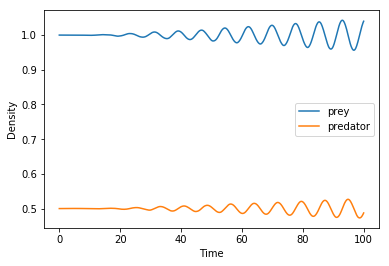

In [76]:
solve_plot(*xy0, tmax=100, b=b, h=h, ϵ=ϵ, d=d)

It is not stable.  
We can see that from analysis, too, by deriving the Jacobian (the partial derivatives matrix), evaluating it at the equiblirum $(x^*, y^*)$, and finding the leading eigenvalue (or spectral radius) which is the largest eigenvalue.
If the leading eigenvalue is positive -- the equilibrium is unstable; if it is negative, the equilibrium is stable; if it is zero, this method is insufficient.

In [83]:
def jacobian(xy, b, h, ϵ, d):
    x, y = xy
    return np.array(
        [
            [b - h * y, - h * x],
            [ϵ * h * y, ϵ * h * x - d]
        ]
    )

In [85]:
xystar = d/(ϵ*h), b/h

J = jacobian(xystar, b, h, ϵ, d)
print(J)

[[ 0.         -1.33333333]
 [ 0.5         0.        ]]


In [90]:
eigs = np.linalg.eigvals(J)
ρ = max(abs(eigs))
print('spectral radius:', ρ)
print('stability:', ρ < 0)

spectral radius: 0.816496580928
stability: False


In [101]:
def spec_rad(b, h, ϵ, d):
    xystar =  d/(ϵ*h), b/h
    J = jacobian(xystar, b, h, ϵ, d)
    eigs = np.linalg.eigvals(J)
    return max(abs(eigs))

In [102]:
b = 2/3
h = 4/3

ϵs = np.linspace(1e-6, 1, 51)
ds = np.linspace(1e-6, 1, 50)

ρs = [spec_rad(b, h, ϵ, d) for ϵ in ϵs for d in ds]
ρs = np.array(ρs).reshape(51, 50)

Unstable across range? True


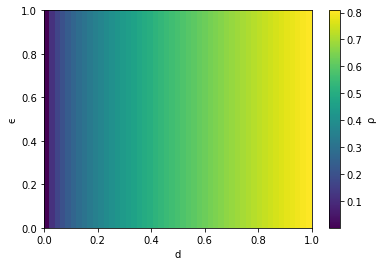

In [108]:
plt.pcolormesh(ds, ϵs, ρs)
plt.colorbar(label='ρ')
plt.xlabel('d')
plt.ylabel('ϵ')

print('Unstable across range?', (ρs > 0).all())

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)